In [74]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [58]:
data = 'WHO-COVID-19-global-data.csv'

In [47]:
def get_country_df(country):
    df = pd.read_csv(data)
    df.columns = [i.strip() for i in df.columns]
    df.rename(columns={'Date_reported' : 'Date'}, inplace = True)
    df['Date'] = pd.to_datetime(df['Date'])
    country_groups = df.groupby('Country')
    country_df = country_groups.get_group(country)
    return country_df

In [366]:
def get_cases(country, how = 'New_cases', start_date = None, end_date = None):
    country_df = get_country_df(country)
    country_df.set_index('Date', inplace = True)

    if start_date is None:
        filt = country_df[how] >= 1

        country_df = country_df[filt]
    
        return country_df.loc[:, [how]]
    
    else:
        return country_df.loc[start_date:end_date, [how]]

In [365]:
def get_deaths(country, how = 'New_deaths', start_date = None, end_date = None):
    country_df = get_country_df(country)
    country_df.set_index('Date', inplace = True)

    if start_date is None:

        filt = country_df[how] >= 1

        country_df = country_df[filt]

        return country_df.loc[:, [how]]

    else:
        return country_df.loc[start_date:end_date, [how]]

In [372]:
def get_country_dictionary(countries, plot, plot_type = 'line', start_date = None, end_date = None):
    country_dictionary = {}
    
    for i in countries:
        if plot.lower() == "new cases":
            if plot_type != 'bar':
                country_dictionary[i] = get_cases(i)
            else:
                country_dictionary[i] = get_cases(i, start_date=start_date, end_date=end_date)
        
        elif plot.lower() == 'total cases':
            if plot_type != 'bar':
                country_dictionary[i] = get_cases(i, 'Cumulative_cases')
            else:
                country_dictionary[i] = get_cases(i, 'Cumulative_cases', start_date=start_date, end_date=end_date)
            
        elif plot.lower() == 'new deaths':
            if plot_type != 'bar':
                country_dictionary[i] = get_deaths(i)
            
            else:
                country_dictionary[i] = get_deaths(i, start_date=start_date, end_date=end_date)
            
        elif plot.lower() == 'total deaths':
            if plot_type != 'bar':
                country_dictionary[i] = get_deaths(i, 'Cumulative_deaths') 
            else:
                country_dictionary[i] = get_deaths(i, 'Cumulative_deaths', start_date=start_date, end_date=end_date)
                
    if plot_type == 'bar':    
        country_dictionary = {
            key: country_dictionary[key] 
            for key in sorted(country_dictionary, key = lambda k: len(country_dictionary[k]))
        }
        
    return country_dictionary

In [415]:
def plot_line(countries, plot = 'new cases', plot_type = 'line'):
    
    if not isinstance(countries, list) and not isinstance(countries, tuple):
        raise TypeError("Please pass in a list/tuple of Country/Countries")
        return
    
    # country comes in as a list
     
    %matplotlib notebook    
    plt.style.use('seaborn-colorblind')
    plt.figure(figsize=(10,5))
    plt.xticks(rotation = 45)
    
    plt.ylabel(plot.upper())
    plt.xlabel('Month')
    
    words = [(i[0].upper() + i[1:]) for i in plot.strip().split(' ')]
    to_add = '' if plot.lower().strip().split(' ')[0] != 'new' else '/Day'
    plt.title(words[0] + ' COVID-19 ' + words[1] + to_add) 
   
    
    country_dictionary = get_country_dictionary(countries, plot, plot_type)
    
    
    keys = list(country_dictionary.keys())
    
    print(country_dictionary.keys())
    
    i = -1#len(countries) // 2 - len(countries)
    width = 0.5
    x_indices = None
    
    
    if plot_type == 'bar':
        longest = country_dictionary[keys[0]]
        
        start_date, end_date = (longest.index[0], longest.index[-1])
        
        country_dictionary = get_country_dictionary(countries, plot, plot_type, start_date, end_date)
        
        x_indices = np.arange(len(country_dictionary[keys[0]]))
            
    
    for country in countries:   
        dates = country_dictionary[country].index

        if plot.lower() == "new cases":
            y = country_dictionary[country]['New_cases']
        
        elif plot.lower() == 'total cases':
            y = country_dictionary[country]['Cumulative_cases']
            
        elif plot.lower() == 'new deaths':
            y = country_dictionary[country]['New_deaths']
            
        elif plot.lower() == 'total deaths':
            y = country_dictionary[country]['Cumulative_deaths']
        
        if plot_type == 'line':
            plt.plot(dates, y, label = country, alpha = 0.75)
        
        else:
            plt.bar(x_indices + i * width , y, label = country, width = width, alpha = 0.75) 

            i += 1
#     if plot_type == 'bar':        
#         plt.xticks(ticks = x_labels, labels = country_dictionary[countries[0]].index)
    
    
    plt.legend()


In [187]:
india = get_country_df('India')

filt = india['New_cases'] >= 1

ifilt = india[filt]

print(ifilt.loc[ifilt.index[0], 'Date'] - ifilt.loc[ifilt.index[-1], 'Date'])


-236 days +00:00:00


In [282]:
d = {"one": [(1,3),(1,4)], "two": [(1,2),(1,2),(1,3)], "three": [(1,1)]}

d = {key:d[key] for key in sorted(d, key = lambda k: len(d[k])) }

# d = sorted(d)
print(d.keys())
d

dict_keys(['three', 'one', 'two'])


{'three': [(1, 1)], 'one': [(1, 3), (1, 4)], 'two': [(1, 2), (1, 2), (1, 3)]}

In [417]:
df

,Date,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0
2,2020-01-05,AF,Afghanistan,EMRO,0,0,0,0
3,2020-01-06,AF,Afghanistan,EMRO,0,0,0,0
4,2020-01-07,AF,Afghanistan,EMRO,0,0,0,0
...,...,...,...,...,...,...,...,...
62035,2020-09-18,ZW,Zimbabwe,AFRO,35,7633,0,224
62036,2020-09-19,ZW,Zimbabwe,AFRO,14,7647,0,224
62037,2020-09-20,ZW,Zimbabwe,AFRO,25,7672,1,225
62038,2020-09-21,ZW,Zimbabwe,AFRO,11,7683,0,225


In [459]:
def plot_pie(date, plot = 'total cases'):
    d = {
        'total cases' : "Cumulative_cases",
        'new cases' : 'New_cases',
        'total deaths' : 'Cumulative_deaths',
        'new deaths' : 'New_deaths'
    }
    cases = df.groupby('Date').get_group(date).sort_values(by = d[plot], ascending = False)[d[plot]][:15]
    labels = df.groupby('Date').get_group(date).sort_values(by = d[plot], ascending = False)['Country'][:15]
    
    plt.figure(figsize=(10,5))
    plt.style.use('seaborn-colorblind')
    plt.title(f'Percentage of {plot.upper()} shared by Top 15 Countries on {date}')
    plt.pie(cases,autopct='%1.0f%%', labels = labels, pctdistance = 0.9, radius = 1.3, textprops={'size': 'smaller'});

<IPython.core.display.Javascript object>


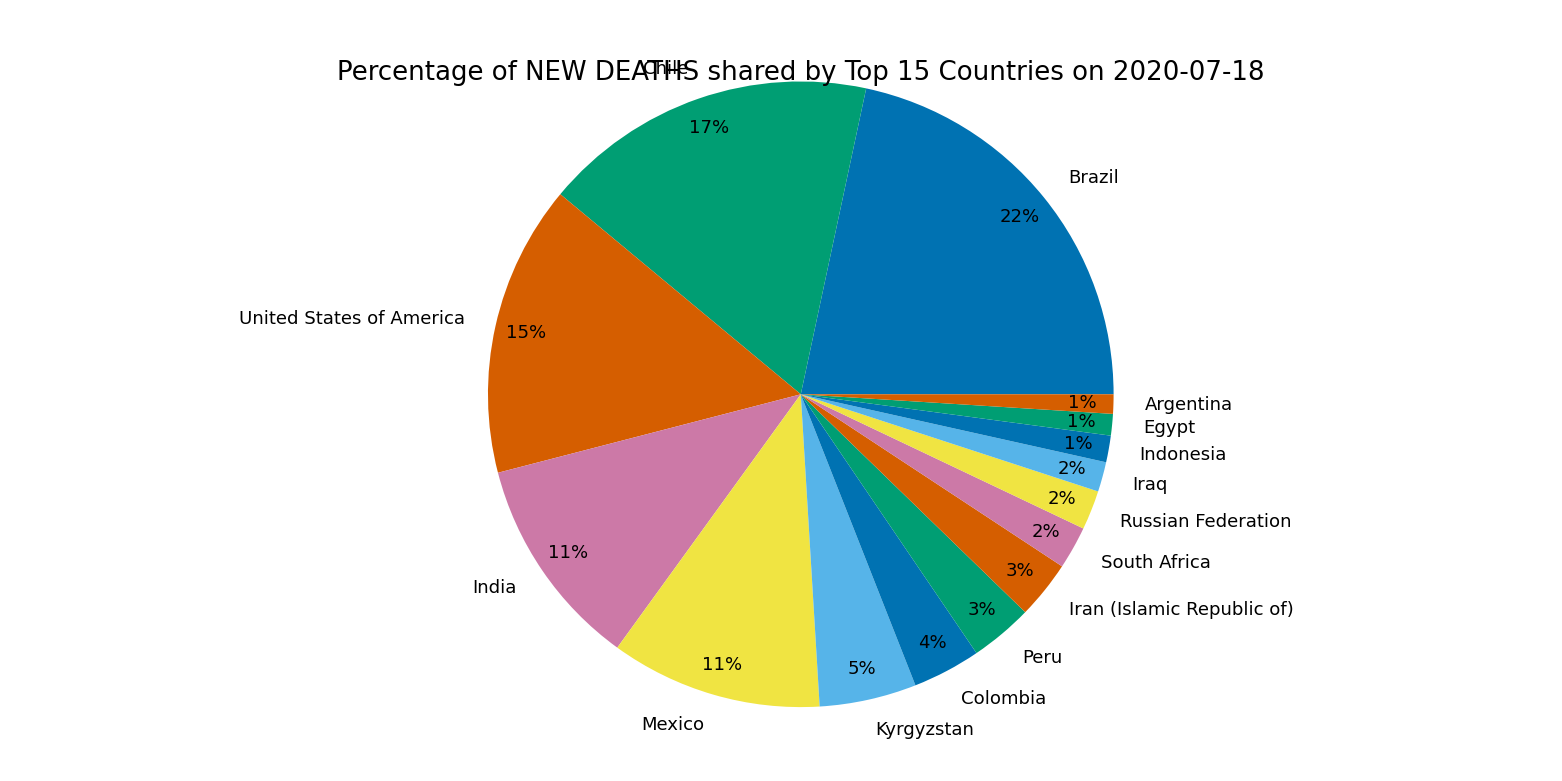

In [464]:
plot_pie('2020-07-18', 'new deaths')